### Lecture d'une image RGB

On peut commencer par afficher une des images et voir à quoi elle ressemble

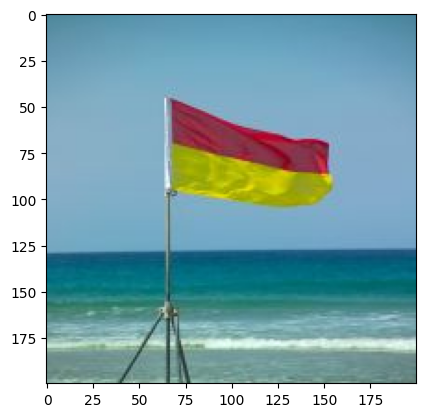

In [1]:
import matplotlib.pyplot as plt

# affichage de l'image 45

img = plt.imread('Images/Images/45.jpg')
plt.imshow(img)

In [2]:
img.shape # dimension de l'image : 200x200 sur 3 canaux (RGB)

(200, 200, 3)

### Impact de la quantification

Nous allons quantifier l'image : il s'agit d'un sous-échantillonnage sur les 2 bits de poids forts pour chaque composante.

On utilisera la fonction *bitwise_and* de *numpy* afin d'accéder à la valeur d'un bit.

Exemple : pour récupérer la valeur du 1er bit de poids fort (bit7 --> $2^7$ = $128$) du nombre n : np.*bitwise_and(n,$128$)* renverra $0$ ou $128$.

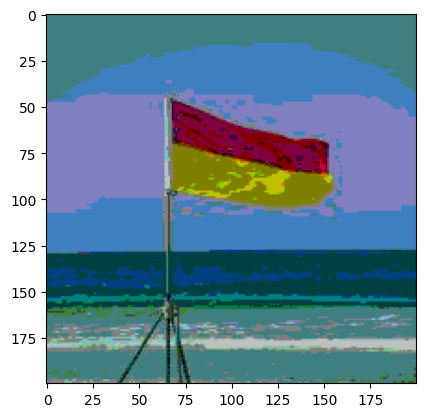

In [3]:
import numpy as np

img_quanti = np.bitwise_and(img,192) # 192 car les valeurs des bits de poids poids sont 128 et 64
plt.imshow(img_quanti)


On remarque que les couleurs sont plus marqué sur l'image. On a plus de dégradés, les transitions sont nettes car seules 4 valeurs par canal sont conservées.

In [4]:
np.unique(img_quanti) # affiche chaque unique occurence des valeurs

array([  0,  64, 128, 192], dtype=uint8)

### Calcul du rmse

Calculons l'erreur quadratique moyenne entre l'image de départ et l'image quantifiée

In [5]:
rmse = np.sqrt(np.mean((np.float32(img_quanti) - np.float32(img))**2))
rmse

np.float32(36.282444)

On a un RMSE de $36.28$, cela indique une perte importante de qualité par rapport à l’image originale, ce qui est cohérent avec une quantification sur les 2 bits de poids fort.

### 2. Quantification de la couleur

Nous allons maintenant écrire une fonction qui va effectuer cette opération sur chaque image.
Concrètement, pour chaque image *img* une image quantifiée *img_quantifie* à 2 dimensions contenant des valeurs entre 0 ou 63 sera créée à partir des 2 bits de poids forts de chacune des composantes couleurs.
2 bits pour le Rouge, 2 bits pour le Vert et 2 bits pour le Bleu : 6 bits soit 64 valeurs possibles.

Pour cela j'ai choisi ici l'ordre *RGB* (Rouge, Vert, Bleu) mais on aurait très bien pu utiliser *GBR* par exemple.

In [6]:

def quantification(img):
    bit7_rouge = (np.bitwise_and(img[:,:,0],128)/128)*2**5
    bit6_rouge = (np.bitwise_and(img[:,:,0],64)/64)*2**4
    bit7_vert = (np.bitwise_and(img[:,:,1],128)/128)*2**3
    bit6_vert = (np.bitwise_and(img[:,:,1],64)/64)*2**2
    bit7_bleu = (np.bitwise_and(img[:,:,2],128)/128)*2**1
    bit6_bleu = (np.bitwise_and(img[:,:,2],64)/64)*2**0
    img = bit7_rouge+bit6_rouge+bit7_vert+bit6_vert+bit7_bleu+bit6_bleu
    return img

# application de la fonction
q_img = quantification(img)


np.unique(q_img)


array([ 0.,  1.,  4.,  5.,  6.,  9., 10., 16., 17., 20., 21., 22., 24.,
       25., 26., 27., 32., 33., 36., 37., 38., 40., 41., 42., 43., 44.,
       45., 46., 47., 48., 49., 52., 54., 56., 57., 58., 60., 61., 63.])

On a bien $64$ valeurs entre $0$ et $63$ 

In [7]:
len(np.unique(q_img
              ))

39

### Histo 

Nous allons maintenant indexer cette image quantifiée par son histogramme de couleur.

In [8]:
def histogramme(img):
    histogramme = [0]*64  # 64 cases initialisées à zéro
    
    # parcours des pixels et comptage des occurences
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = int(img[i, j])  
            histogramme[val] += 1  # incrémentation

    return histogramme



In [9]:
print(histogramme(q_img))

[32, 2, 0, 0, 36, 4037, 1448, 0, 0, 214, 508, 0, 0, 0, 0, 0, 108, 106, 0, 0, 29, 254, 11, 0, 1, 331, 10381, 8584, 0, 0, 0, 0, 501, 791, 0, 0, 55, 25, 28, 0, 1373, 103, 1734, 7714, 76, 6, 218, 437, 2, 11, 0, 0, 3, 0, 2, 0, 40, 3, 2, 0, 230, 4, 0, 560]


<BarContainer object of 64 artists>

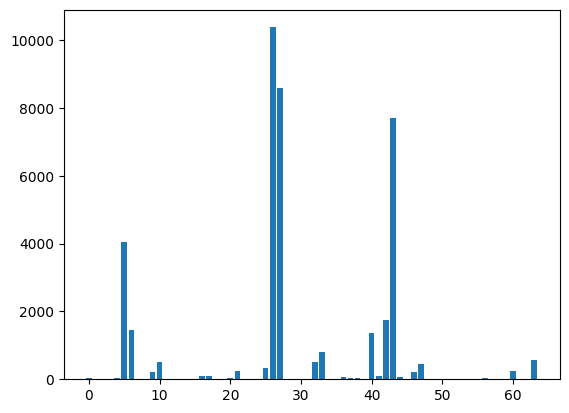

In [10]:
# affichage de l'histogramme

plt.bar(np.arange(64), histogramme(q_img))

### 5. Indexation

Nous allons maintenant applique le processus d'indexation sur chaque image

In [11]:
import os

def indexation(path):
    fichiers = [f for f in os.listdir(path)]
    images = []
    for f in fichiers:
        img = plt.imread(os.path.join(path, f))
        images.append(img)
    
    histogrammes = []
    for i in range(len(images)):
        histogramme_img = histogramme(quantification(images[i]))
        histogrammes.append(histogramme_img)
    return histogrammes


On peut maintenant choisir une image et renvoyer les 5 images les plus similaires.
On utilisera une similarité basé sur une fonction de distance du type intersection d'histogrammes sur les histogrammes en couleur issus de l'indexation.


In [12]:
chemin = 'Images/Images' # chemin vers le répertoire
histogrammes = indexation(chemin) # indexation des images

In [13]:
# fonction de similarité basé sur l'intersection d'histogrammes

def similarite(histogrammes, num_image):
    hist_ref = np.array(histogrammes[num_image - 1])
    similarites = {}  # dictionnaire : {indice_image: similarité avec l'image num_image}

    for i in range(len(histogrammes)):
        if i != (num_image - 1):
            hist_i = np.array(histogrammes[i])
            sim = np.sum(np.minimum(hist_ref, hist_i))
            similarites[i] = sim 

    return similarites


Mise en application

In [14]:
num_image = int(input("Entrez un numéro d'image: "))

In [15]:
liste_similarite = similarite(histogrammes, num_image)

# trie de la liste de similarité dans l'ordre décroissant
plus_fortes = sorted(liste_similarite.items(), key=lambda x: x[1], reverse=True)
top10 = plus_fortes[:5] # 5 images les plus similaires à l'image num_image
indices_simi = []
for idx, val in top10:
    indices_simi.append(idx+1)
    print(f"Image {idx+1} : similarité = {val:.2f}")

Image 14 : similarité = 31943.00
Image 30 : similarité = 29187.00
Image 31 : similarité = 27822.00
Image 11 : similarité = 25305.00
Image 48 : similarité = 25017.00


On peut ensuite afficher l'image en question puis les images similaires

Text(0.5, 1.0, 'Image de référence')

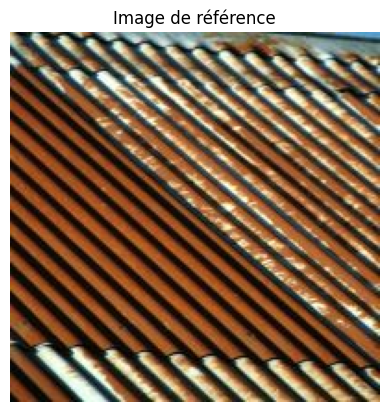

In [16]:
plt.imshow(plt.imread(f'Images/Images/{num_image}.jpg'))
plt.axis("off")
plt.title("Image de référence")

Les images similaires

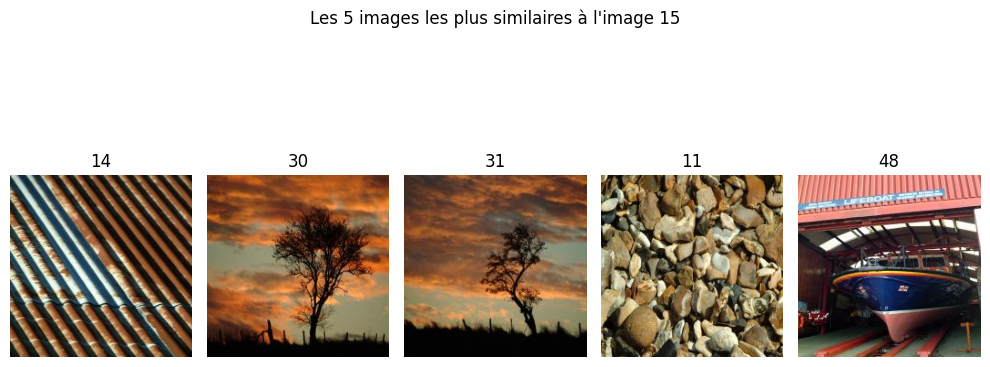

In [17]:
cols = 5
rows = 1
figure = plt.figure(figsize=(10, 5))
plt.suptitle(f"Les {5} images les plus similaires à l'image {num_image}")

for i in range(len(indices_simi)):
    figure.add_subplot(rows, cols, i+1)
    plt.title(indices_simi[i])
    img = plt.imread(f'Images/Images/{str(indices_simi[i]).zfill(2)}.jpg')
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


L'image la plus similaire, l'image 14 est très similaire à l'image 15. Il s'agit peut être même d'une photo du même toit.

##### **On peut maintenant refaire le même processus en faisant un sous-échantillonnage sur les 3 bits de poids forts pour chaque composante.**

In [18]:

def quantification3(img):
    bit7_rouge = (np.bitwise_and(img[:,:,0],128)/128)*2**8
    bit6_rouge = (np.bitwise_and(img[:,:,0],64)/64)*2**7
    bit5_rouge = (np.bitwise_and(img[:,:,0],32)/32)*2**6
    bit7_vert = (np.bitwise_and(img[:,:,1],128)/128)*2**5
    bit6_vert = (np.bitwise_and(img[:,:,1],64)/64)*2**4
    bit5_vert = (np.bitwise_and(img[:,:,1],32)/32)*2**3
    bit7_bleu = (np.bitwise_and(img[:,:,2],128)/128)*2**2
    bit6_bleu = (np.bitwise_and(img[:,:,2],64)/64)*2**1
    bit5_bleu = (np.bitwise_and(img[:,:,2],32)/32)*2**0
    img = bit7_rouge+bit6_rouge+bit5_rouge+bit7_vert+bit6_vert+bit5_vert+bit7_bleu+bit6_bleu+bit5_bleu
    return img

# application de la fonction
q_img = quantification3(img)


np.unique(q_img)


array([  0.,   1.,   2.,   8.,   9.,  10.,  11.,  18.,  19.,  64.,  65.,
        66.,  72.,  73.,  74.,  75.,  80.,  81.,  82.,  83.,  84.,  90.,
        91., 128., 129., 136., 137., 138., 139., 144., 145., 146., 147.,
       148., 153., 154., 155., 156., 157., 192., 193., 200., 201., 202.,
       208., 209., 210., 211., 212., 216., 217., 218., 219., 220., 221.,
       226., 227., 228., 229., 230., 237., 238., 256., 257., 264., 265.,
       266., 272., 273., 274., 275., 280., 281., 282., 283., 284., 288.,
       289., 290., 291., 292., 293., 294., 299., 300., 301., 302., 303.,
       310., 311., 321., 328., 329., 336., 337., 338., 339., 344., 345.,
       346., 347., 348., 353., 354., 355., 356., 357., 361., 362., 364.,
       365., 366., 373., 374., 375., 383., 392., 393., 400., 401., 402.,
       403., 408., 409., 410., 411., 412., 416., 417., 418., 419., 420.,
       421., 425., 426., 427., 428., 429., 430., 433., 434., 437., 438.,
       439., 445., 446., 447., 464., 466., 472., 47

In [19]:
def histogramme3(img):
    histogramme = [0]*512  # 64 cases initialisées à zéro
    
    # parcours des pixels et comptage des occurences
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = int(img[i, j])  
            histogramme[val] += 1  # incrémentation

    return histogramme



In [20]:
def indexation3(path):
    fichiers = [f for f in os.listdir(path)]
    images = []
    for f in fichiers:
        img = plt.imread(os.path.join(path, f))
        images.append(img)
    
    histogrammes = []
    for i in range(len(images)):
        histogramme_img = histogramme3(quantification3(images[i]))
        histogrammes.append(histogramme_img)
    return histogrammes


Text(0.5, 1.0, 'Histogramme quantification 3 bits')

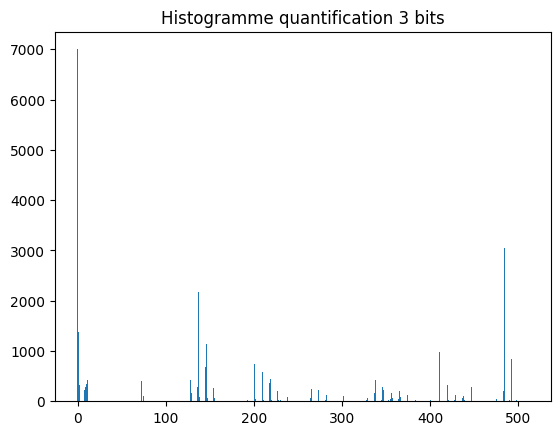

In [21]:
plt.bar(np.arange(512), histogramme3(q_img), )
plt.title("Histogramme quantification 3 bits")

In [22]:
histogrammes3 = indexation3(chemin) # indexation des images

On garde la même image que précédemment (n° 15)

Calcul des similarités

In [23]:
liste_similarite3 = similarite(histogrammes3, num_image)

# trie de la liste de similarité dans l'ordre décroissant
plus_fortes_3b = sorted(liste_similarite3.items(), key=lambda x: x[1], reverse=True)
top10_3b = plus_fortes_3b[:5] # 5 images les plus similaires à l'image num_image

print("5 images les plus similaires à l'image 15 avec un echantillonage sur 2 bits\n")
for idx, val in top10:
    print(f"Image {idx+1} : similarité = {val:.2f}")

print("\n\n5 images les plus similaires à l'image 15 avec un echantillonage sur 2 bits")
indices_simi_3b = []
for idx, val in top10_3b:
    indices_simi_3b.append(idx+1)
    print(f"Image {idx+1} : similarité = {val:.2f}")

5 images les plus similaires à l'image 15 avec un echantillonage sur 2 bits

Image 14 : similarité = 31943.00
Image 30 : similarité = 29187.00
Image 31 : similarité = 27822.00
Image 11 : similarité = 25305.00
Image 48 : similarité = 25017.00


5 images les plus similaires à l'image 15 avec un echantillonage sur 2 bits
Image 14 : similarité = 30317.00
Image 30 : similarité = 24873.00
Image 31 : similarité = 22335.00
Image 11 : similarité = 20845.00
Image 10 : similarité = 20820.00


On remarque qu'il n'y a pas trop de changement à part la dernière image qui est remplacé par l'image n°10. Affichons l'image 10, 15 et 48 côte à côte.

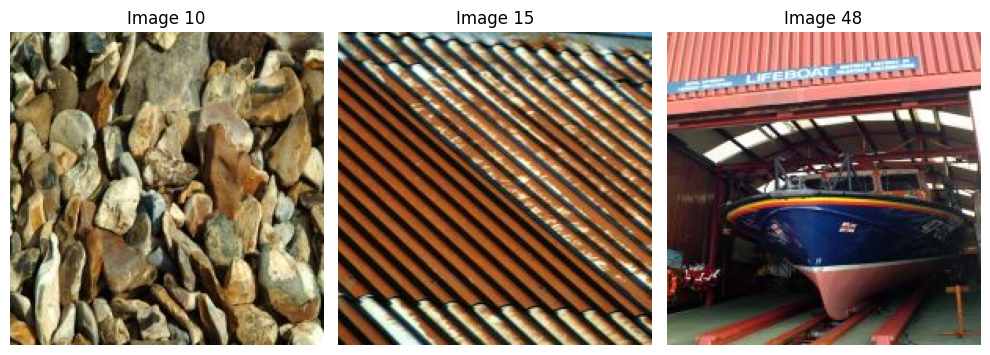

In [24]:
cols = 3
rows = 1
figure = plt.figure(figsize=(10, 5))
liste_images = [10,15,48]
for i in range(len(liste_images)):
    figure.add_subplot(rows, cols, i+1)
    plt.title(f"Image {liste_images[i]}")
    img = plt.imread(f'Images/Images/{str(liste_images[i]).zfill(2)}.jpg')
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

 L'image 10 est légèrement plus similaire à l'image 15 par rapport à l'image 48, en terme de couleur.

Conclusion : Ces résultats laissent penser que pour la quantification, un échantillonage sur 2 bits pourrait être suffisant